http://ataspinar.com/2017/05/26/classification-with-scikit-learn/

In [1]:
#This is a notebook containing the code of blogpost http://ataspinar.com/2017/05/26/classification-with-scikit-learn/
#Although I'll also give a short description in this notebook, for a full explanation you should read the blog.

# Lets import some modules for basic computation
import time
import pandas as pd
import numpy as np

import pickle

# Some modules for plotting and visualizing
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# And some Machine Learning modules from scikit-learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#These Classifiers have been commented out because they take too long and do not give more accuracy as the other ones.
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.gaussian_process import GaussianProcessClassifier

In [2]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    #"AdaBoost": AdaBoostClassifier(),
    #"QDA": QuadraticDiscriminantAnalysis(),
    #"Gaussian Process": GaussianProcessClassifier()
}

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.
    
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models

def label_encode(df, list_columns):
    """
    This method one-hot encodes all column, specified in list_columns
    
    """
    for col in list_columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)

        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed      

def expand_columns(df, list_columns):
    for col in list_columns:
        colvalues = df[col].unique()
        for colvalue in colvalues:
            newcol_name = "{}_is_{}".format(col, colvalue)
            df.loc[df[col] == colvalue, newcol_name] = 1
            df.loc[df[col] != colvalue, newcol_name] = 0
    df.drop(list_columns, inplace=True, axis=1)
        
def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test

def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))

def display_corr_with_col(df, col):
    correlation_matrix = df.corr()
    correlation_type = correlation_matrix[col].copy()
    abs_correlation_type = correlation_type.apply(lambda x: abs(x))
    desc_corr_values = abs_correlation_type.sort_values(ascending=False)
    y_values = list(desc_corr_values.values)[1:]
    x_values = range(0,len(y_values))
    xlabels = list(desc_corr_values.keys())[1:]
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar(x_values, y_values)
    ax.set_title('The correlation of all features with {}'.format(col), fontsize=20)
    ax.set_ylabel('Pearson correlatie coefficient [abs waarde]', fontsize=16)
    plt.xticks(x_values, xlabels, rotation='vertical')
    plt.show()

# 1. The glass - dataset

In [3]:
filename_glass = './data/glass.csv'

In [4]:
df_glass = pd.read_csv(filename_glass)
print("This dataset has nrows, ncols: {}".format(df_glass.shape))
display(df_glass.head())

display(df_glass.describe())

This dataset has nrows, ncols: (214, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


## 1.3 Classification

In [5]:
y_col_glass = 'Type'
x_cols_glass = list(df_glass.columns.values)
x_cols_glass.remove(y_col_glass)

train_test_ratio = 0.7
df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(df_glass, y_col_glass, x_cols_glass, train_test_ratio)

dict_models = batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 8)
display_dict_models(dict_models)

trained Linear SVM in 0.00 s
trained Logistic Regression in 0.01 s
trained Neural Net in 0.04 s
trained Naive Bayes in 0.00 s
trained Nearest Neighbors in 0.00 s
trained Random Forest in 1.58 s
trained Gradient Boosting Classifier in 2.14 s
trained Decision Tree in 0.00 s


,classifier,train_score,test_score,train_time
6,Gradient Boosting Classifier,1.00000,0.777778,2.139870
5,Random Forest,1.00000,0.722222,1.581734
7,Decision Tree,1.00000,0.629630,0.001439
0,Linear SVM,0.73125,0.611111,0.003809
1,Logistic Regression,0.60625,0.611111,0.007491
3,Naive Bayes,0.56875,0.518519,0.002580
4,Nearest Neighbors,0.76875,0.518519,0.003735
2,Neural Net,0.34375,0.277778,0.044877


# 2. Mushroom dataset (containing categorical data)

In [6]:
filename_mushrooms = './data/mushrooms.csv'
df_mushrooms = pd.read_csv(filename_mushrooms)
display(df_mushrooms.head())

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 2.1 Preprocessing the Dataset

In [7]:
for col in df_mushrooms.columns.values:
    print(col, df_mushrooms[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


### 2.1.1 Remove columns with only 1 value

In [8]:
for col in df_mushrooms.columns.values:
    if len(df_mushrooms[col].unique()) <= 1:
        print("Removing column {}, which only contains the value: {}".format(col, df_mushrooms[col].unique()[0]))

Removing column veil-type, which only contains the value: p


### 2.1.2 Handling columns with missing or incorrect values

Some datasets contain missing values like NaN, null, NULL, '?', '??' etc

It could be that all missing values are of type NaN, or that some columns contain NaN and other columns contain missing data in the form of '??'.

It is up to your best judgement to decide what to do with these missing values. 
What is most effective, really depends on the type of data, the type of missing data and the ratio between missing data and non-missing data. 

- If the number of rows containing missing data is only a few percent of the total dataset, the best option could be to drop those rows. 

- If there is a column which contains almost all missing data, it will not have much added value and it might be best to drop that column.

- It could be that a value not being filled in also is information which helps with the classification and it is best to leave it like it is. 

- etc

### 2.1.2.1 Drop rows with missing values

In [9]:
print("Number of rows in total: {}".format(df_mushrooms.shape[0]))
print("Number of rows with missing values in column 'stalk-root': {}".format(df_mushrooms[df_mushrooms['stalk-root'] == '?'].shape[0]))
df_mushrooms_dropped_rows = df_mushrooms[df_mushrooms['stalk-root'] != '?']

Number of rows in total: 8124
Number of rows with missing values in column 'stalk-root': 2480


### 2.1.2.2 Drop column with more than X percent missing values

In [10]:
drop_percentage = 0.8

df_mushrooms_dropped_cols = df_mushrooms.copy(deep=True)
df_mushrooms_dropped_cols.loc[df_mushrooms_dropped_cols['stalk-root'] == '?', 'stalk-root'] = np.nan

for col in df_mushrooms_dropped_cols.columns.values:
    no_rows = df_mushrooms_dropped_cols[col].isnull().sum()
    percentage = no_rows / df_mushrooms_dropped_cols.shape[0]
    if percentage > drop_percentage:
        del df_mushrooms_dropped_cols[col]
        print("Column {} contains {} missing values. This is {} percent. Dropping this column.".format(col, no_rows, percentage))

### 2.1.2.3 Fill missing values with zero / -1

In [12]:
df_mushrooms_zerofill = df_mushrooms.copy(deep = True)
df_mushrooms_zerofill.loc[df_mushrooms_zerofill['stalk-root'] == '?', 'stalk-root'] = np.nan
df_mushrooms_zerofill.fillna(0, inplace=True)

### 2.1.2.4 Fill missing values with backward fill

In [11]:
df_mushrooms_bfill = df_mushrooms.copy(deep = True)
df_mushrooms_bfill.loc[df_mushrooms_bfill['stalk-root'] == '?', 'stalk-root'] = np.nan
df_mushrooms_bfill.fillna(method='bfill', inplace=True)

### 2.1.2.5 Fill missing values with forward fill

In [13]:
df_mushrooms_ffill = df_mushrooms.copy(deep = True)
df_mushrooms_ffill.loc[df_mushrooms_ffill['stalk-root'] == '?', 'stalk-root'] = np.nan
df_mushrooms_ffill.fillna(method='ffill', inplace=True)

## 2.2 Handling columns with categorical data
When it comes to columns with categorical data, you can do two things. 

- 1) One-hot encode the columns such that they are converted to numerical values. 
- 2) Expand the column into N different columns containing binary values. 



** Example: **

Let assume that we have a column called 'FRUIT' with unique values ['ORANGE', 'APPLE', PEAR'].
 - In the first case it would be converted to the unique values [0, 1, 2]
 - In the second case it would be converted into three different columns called ['FRUIT_IS_ORANGE', 'FRUIT_IS_APPLE', 'FRUIT_IS_PEAR'] and after this the original column 'FRUIT' would be deleted. The three new columns contain the values 1 or 0 depending on the value of the original column.


When using the first method, you should pay attention to the fact that some classifiers will try to make sense of the numerical value of the one-hot encoded column. For example the Nearest neighbour algorithm assumes that the value 1 is closer to 0 than the value 2. But the numerical values have no meaning in the case of one-hot encoded columns (an APPLE is not closer to an ORANGE than a PEAR is.). And the results therefore can be misleading.



### 2.2.1 One-Hot encoding the columns with categorical data

In [14]:
df_mushrooms_ohe = df_mushrooms.copy(deep=True)
to_be_encoded_cols = df_mushrooms_ohe.columns.values
label_encode(df_mushrooms_ohe, to_be_encoded_cols)
display(df_mushrooms_ohe.head())

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [15]:
## Now lets do the same thing for the other dataframes
df_mushrooms_dropped_rows_ohe = df_mushrooms_dropped_rows.copy(deep = True)
df_mushrooms_zerofill_ohe = df_mushrooms_zerofill.copy(deep = True)
df_mushrooms_bfill_ohe = df_mushrooms_bfill.copy(deep = True)
df_mushrooms_ffill_ohe = df_mushrooms_ffill.copy(deep = True)

label_encode(df_mushrooms_dropped_rows_ohe, to_be_encoded_cols)
label_encode(df_mushrooms_zerofill_ohe, to_be_encoded_cols)
label_encode(df_mushrooms_bfill_ohe, to_be_encoded_cols)
label_encode(df_mushrooms_ffill_ohe, to_be_encoded_cols)

### 2.2.2 Expanding the columns with categorical data

In [16]:
y_col = 'class'
to_be_expanded_cols = list(df_mushrooms.columns.values)
to_be_expanded_cols.remove(y_col)

df_mushrooms_expanded = df_mushrooms.copy(deep=True)
label_encode(df_mushrooms_expanded, [y_col])
expand_columns(df_mushrooms_expanded, to_be_expanded_cols)
display(df_mushrooms_expanded.head())

,class,cap-shape_is_x,cap-shape_is_b,cap-shape_is_s,cap-shape_is_f,cap-shape_is_k,cap-shape_is_c,cap-surface_is_s,cap-surface_is_y,cap-surface_is_f,...,population_is_v,population_is_y,population_is_c,habitat_is_u,habitat_is_g,habitat_is_m,habitat_is_d,habitat_is_p,habitat_is_w,habitat_is_l
0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
## Now lets do the same thing for all other dataframes
df_mushrooms_dropped_rows_expanded = df_mushrooms_dropped_rows.copy(deep = True)
df_mushrooms_zerofill_expanded = df_mushrooms_zerofill.copy(deep = True)
df_mushrooms_bfill_expanded = df_mushrooms_bfill.copy(deep = True)
df_mushrooms_ffill_expanded = df_mushrooms_ffill.copy(deep = True)

label_encode(df_mushrooms_dropped_rows_expanded, [y_col])
label_encode(df_mushrooms_zerofill_expanded, [y_col])
label_encode(df_mushrooms_bfill_expanded, [y_col])
label_encode(df_mushrooms_ffill_expanded, [y_col])

expand_columns(df_mushrooms_dropped_rows_expanded, to_be_expanded_cols)
expand_columns(df_mushrooms_zerofill_expanded, to_be_expanded_cols)
expand_columns(df_mushrooms_bfill_expanded, to_be_expanded_cols)
expand_columns(df_mushrooms_ffill_expanded, to_be_expanded_cols)

## 2.4 Classifying the dataset

We have seen that there are two different ways to handle columns with categorical data, and many different ways to handle missing values. 

Since computation power is cheap, it is easy to try out all of these ways on all of the classifiers present in the scikit-learn. 

After we have seen which method and which classifier has the highest accuracy initially we can continue in that direction. 

In [18]:
dict_dataframes = {
    "df_mushrooms_ohe": df_mushrooms_ohe,
    "df_mushrooms_dropped_rows_ohe": df_mushrooms_dropped_rows_ohe,
    "df_mushrooms_zerofill_ohe": df_mushrooms_zerofill_ohe,
    "df_mushrooms_bfill_ohe": df_mushrooms_bfill_ohe,
    "df_mushrooms_ffill_ohe": df_mushrooms_ffill_ohe,
    "df_mushrooms_expanded": df_mushrooms_expanded,
    "df_mushrooms_dropped_rows_expanded": df_mushrooms_dropped_rows_expanded,
    "df_mushrooms_zerofill_expanded": df_mushrooms_zerofill_expanded,
    "df_mushrooms_bfill_expanded": df_mushrooms_bfill_expanded,
    "df_mushrooms_ffill_expanded": df_mushrooms_ffill_expanded
}

In [19]:
y_col = 'class'
train_test_ratio = 0.7

for df_key, df in dict_dataframes.items():
    x_cols = list(df.columns.values)
    x_cols.remove(y_col)
    df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(df, y_col, x_cols, train_test_ratio)
    dict_models = batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 8, verbose=False)
    
    print()
    print(df_key)
    display_dict_models(dict_models)
    print("-------------------------------------------------------")


df_mushrooms_dropped_rows_ohe


,classifier,train_score,test_score,train_time
0,Linear SVM,1.000000,1.000000,0.135287
2,Neural Net,1.000000,1.000000,3.557156
4,Nearest Neighbors,1.000000,1.000000,0.009476
5,Random Forest,1.000000,1.000000,2.014324
6,Gradient Boosting Classifier,1.000000,1.000000,0.851114
7,Decision Tree,1.000000,1.000000,0.002647
1,Logistic Regression,0.960979,0.961114,0.030164
3,Naive Bayes,0.698291,0.681950,0.004515


-------------------------------------------------------

df_mushrooms_dropped_rows_expanded


,classifier,train_score,test_score,train_time
1,Logistic Regression,1.000000,1.000000,0.020360
2,Neural Net,1.000000,1.000000,2.554877
4,Nearest Neighbors,1.000000,1.000000,0.046498
5,Random Forest,1.000000,1.000000,2.183835
6,Gradient Boosting Classifier,1.000000,1.000000,1.242099
7,Decision Tree,1.000000,1.000000,0.006018
0,Linear SVM,0.998489,0.998805,0.278872
3,Naive Bayes,0.997481,0.991637,0.008817


-------------------------------------------------------

df_mushrooms_zerofill_expanded


,classifier,train_score,test_score,train_time
1,Logistic Regression,1.000000,1.000000,0.032719
4,Nearest Neighbors,1.000000,1.000000,0.088126
5,Random Forest,1.000000,1.000000,2.823201
6,Gradient Boosting Classifier,1.000000,1.000000,2.608610
7,Decision Tree,1.000000,1.000000,0.021161
0,Linear SVM,0.998787,0.999575,0.642152
2,Neural Net,0.999307,0.999575,2.541479
3,Naive Bayes,0.955113,0.950722,0.014075


-------------------------------------------------------

df_mushrooms_bfill_expanded


,classifier,train_score,test_score,train_time
4,Nearest Neighbors,1.000000,1.000000,0.093511
5,Random Forest,1.000000,1.000000,2.881391
1,Logistic Regression,1.000000,0.998777,0.037358
6,Gradient Boosting Classifier,1.000000,0.998777,2.772624
7,Decision Tree,1.000000,0.998777,0.013240
0,Linear SVM,0.999295,0.998369,0.625491
2,Neural Net,0.999295,0.998369,2.801010
3,Naive Bayes,0.966502,0.968597,0.016206


-------------------------------------------------------

df_mushrooms_ohe


,classifier,train_score,test_score,train_time
0,Linear SVM,1.000000,1.000000,0.354968
5,Random Forest,1.000000,1.000000,2.540233
6,Gradient Boosting Classifier,1.000000,1.000000,1.505966
7,Decision Tree,1.000000,1.000000,0.006653
4,Nearest Neighbors,0.999478,0.999159,0.016704
2,Neural Net,0.998260,0.997897,4.541445
1,Logistic Regression,0.951453,0.958351,0.051587
3,Naive Bayes,0.920654,0.930585,0.005937


-------------------------------------------------------

df_mushrooms_ffill_ohe


,classifier,train_score,test_score,train_time
0,Linear SVM,1.000000,1.000000,0.339280
5,Random Forest,1.000000,1.000000,2.566411
6,Gradient Boosting Classifier,1.000000,1.000000,1.464553
7,Decision Tree,1.000000,1.000000,0.006022
4,Nearest Neighbors,0.999472,0.997133,0.013089
2,Neural Net,0.996832,0.995495,3.558759
1,Logistic Regression,0.951954,0.947174,0.051538
3,Naive Bayes,0.917987,0.918100,0.005708


-------------------------------------------------------

df_mushrooms_ffill_expanded


,classifier,train_score,test_score,train_time
4,Nearest Neighbors,1.000000,1.000000,0.120039
5,Random Forest,1.000000,1.000000,2.857002
6,Gradient Boosting Classifier,1.000000,1.000000,2.650919
7,Decision Tree,1.000000,1.000000,0.013361
1,Logistic Regression,1.000000,0.999587,0.032923
2,Neural Net,0.999124,0.999173,3.238183
0,Linear SVM,0.998948,0.998346,0.622385
3,Naive Bayes,0.955653,0.961141,0.016933


-------------------------------------------------------

df_mushrooms_bfill_ohe


,classifier,train_score,test_score,train_time
0,Linear SVM,1.000000,1.000000,0.336865
5,Random Forest,1.000000,1.000000,2.553411
6,Gradient Boosting Classifier,1.000000,1.000000,1.506378
7,Decision Tree,1.000000,1.000000,0.006677
4,Nearest Neighbors,0.998960,0.999576,0.014407
2,Neural Net,0.998093,0.995757,3.937056
1,Logistic Regression,0.949367,0.950785,0.052218
3,Naive Bayes,0.916074,0.912601,0.006093


-------------------------------------------------------

df_mushrooms_expanded


,classifier,train_score,test_score,train_time
4,Nearest Neighbors,1.000000,1.000000,0.092744
5,Random Forest,1.000000,1.000000,2.774937
1,Logistic Regression,1.000000,0.998364,0.037052
6,Gradient Boosting Classifier,1.000000,0.998364,2.590648
7,Decision Tree,1.000000,0.998364,0.014052
2,Neural Net,0.999472,0.997955,3.251959
0,Linear SVM,0.997711,0.995910,0.647259
3,Naive Bayes,0.969889,0.962372,0.015218


-------------------------------------------------------

df_mushrooms_zerofill_ohe


,classifier,train_score,test_score,train_time
0,Linear SVM,1.000000,1.000000,0.354805
5,Random Forest,1.000000,1.000000,2.541881
6,Gradient Boosting Classifier,1.000000,1.000000,1.539739
7,Decision Tree,1.000000,1.000000,0.006565
2,Neural Net,0.997034,0.997074,3.812812
4,Nearest Neighbors,0.999302,0.997074,0.014215
1,Logistic Regression,0.946790,0.951923,0.051348
3,Naive Bayes,0.918876,0.923077,0.006668


-------------------------------------------------------


## 2.5 Improving upon the Classifier: hyperparameter optimization

After you have determined with a quick and dirty method type of filling missing values and which classifier performs best for your dataset, you can improve upon the Classifier by optimizing its hyperparameters.

Since the mushroom dataset already has a high accuracy on the test set, there is not much to improve upon. So demonstrate hyperparameter optimization we'll use the glass dataset again.

In [20]:
GDB_params = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.5, 0.1, 0.01, 0.001],
    'criterion': ['friedman_mse', 'mse', 'mae']
}

df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(df_glass, y_col_glass, x_cols_glass, 0.6)

for n_est in GDB_params['n_estimators']:
    for lr in GDB_params['learning_rate']:
        for crit in GDB_params['criterion']:
            clf = GradientBoostingClassifier(n_estimators=n_est, 
                                             learning_rate = lr,
                                             criterion = crit)
            clf.fit(X_train, Y_train)
            train_score = clf.score(X_train, Y_train)
            test_score = clf.score(X_test, Y_test)
            print("For ({}, {}, {}) - train, test score: \t {:.5f} \t-\t {:.5f}".format(n_est, lr, crit[:4], train_score, test_score))

For (100, 0.5, frie) - train, test score: 	 1.00000 	-	 0.77500
For (100, 0.5, mse) - train, test score: 	 1.00000 	-	 0.75000
For (100, 0.5, mae) - train, test score: 	 1.00000 	-	 0.76250
For (100, 0.1, frie) - train, test score: 	 1.00000 	-	 0.77500
For (100, 0.1, mse) - train, test score: 	 1.00000 	-	 0.77500
For (100, 0.1, mae) - train, test score: 	 0.97761 	-	 0.66250
For (100, 0.01, frie) - train, test score: 	 0.91791 	-	 0.73750
For (100, 0.01, mse) - train, test score: 	 0.91791 	-	 0.73750
For (100, 0.01, mae) - train, test score: 	 0.79104 	-	 0.66250
For (100, 0.001, frie) - train, test score: 	 0.82090 	-	 0.71250
For (100, 0.001, mse) - train, test score: 	 0.82090 	-	 0.70000
For (100, 0.001, mae) - train, test score: 	 0.74627 	-	 0.62500
For (500, 0.5, frie) - train, test score: 	 1.00000 	-	 0.77500
For (500, 0.5, mse) - train, test score: 	 1.00000 	-	 0.76250
For (500, 0.5, mae) - train, test score: 	 0.97761 	-	 0.66250
For (500, 0.1, frie) - train, test score:

# 3. Understanding complex datasets

## 3.1 Correlation Matrix
Some datasets contain a lot of features / columns, and it is not immediatly clear which of these features are helping with the Classification / Regression, and which of these features are only adding more noise. 

To have a better understanding of this, you could make a correlation matrix of the data, and plot all features by descending order of correlation value. 

/usr/local/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


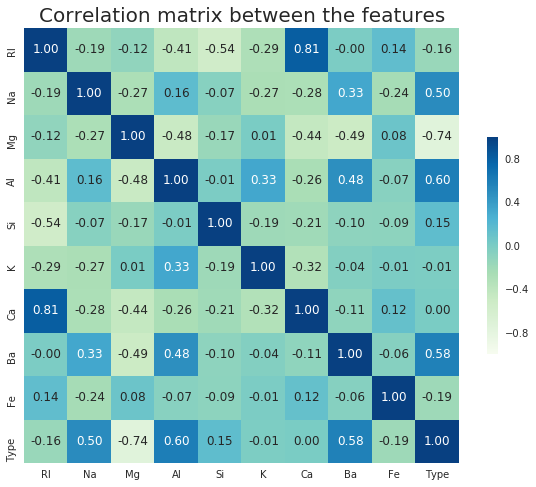

In [21]:
correlation_matrix = df_glass.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True,fmt='.2f', cmap ='GnBu', cbar_kws={"shrink": .5}, robust=True)
plt.title('Correlation matrix between the features', fontsize=20)
plt.show()

/usr/local/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


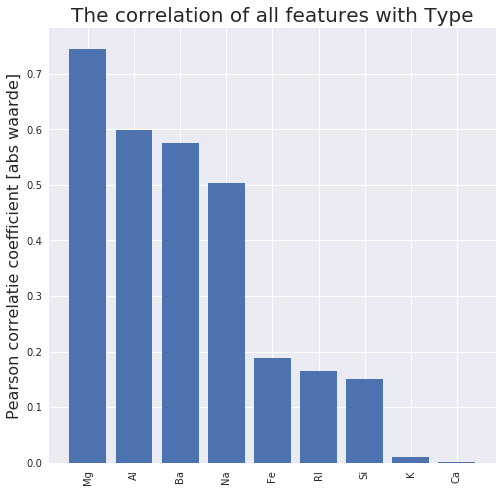

In [22]:
display_corr_with_col(df_glass, 'Type')

## 3.2 Cumulative Explained Variance

The Cumulative explained variance shows how much of the variance is captures by the first x features. 

Below we can see that the first 4 features (i.e. the four features with the largest correlation) already capture 90% of the variance. 

If you have low accuracy values for your Regression / Classification model, you could decide to stepwise remove the features with the lowest correlation, (or stepwise add features with the highest correlation).

/usr/local/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


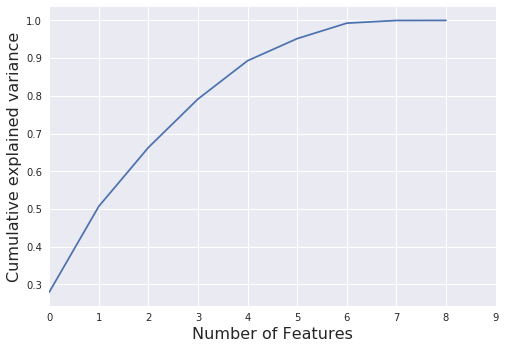

In [23]:
X = df_glass[x_cols_glass].values
X_std = StandardScaler().fit_transform(X)

pca = PCA().fit(X_std)
var_ratio = pca.explained_variance_ratio_
components = pca.components_
#print(pca.explained_variance_)
plt.plot(np.cumsum(var_ratio))
plt.xlim(0,9,1)
plt.xlabel('Number of Features', fontsize=16)
plt.ylabel('Cumulative explained variance', fontsize=16)
plt.show()

## 3.3 Pairwise relationships between the features

In addition to the correlation matrix, you can plot the pairwise relationships between the features, to see **how** these features are correlated. 

/usr/local/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


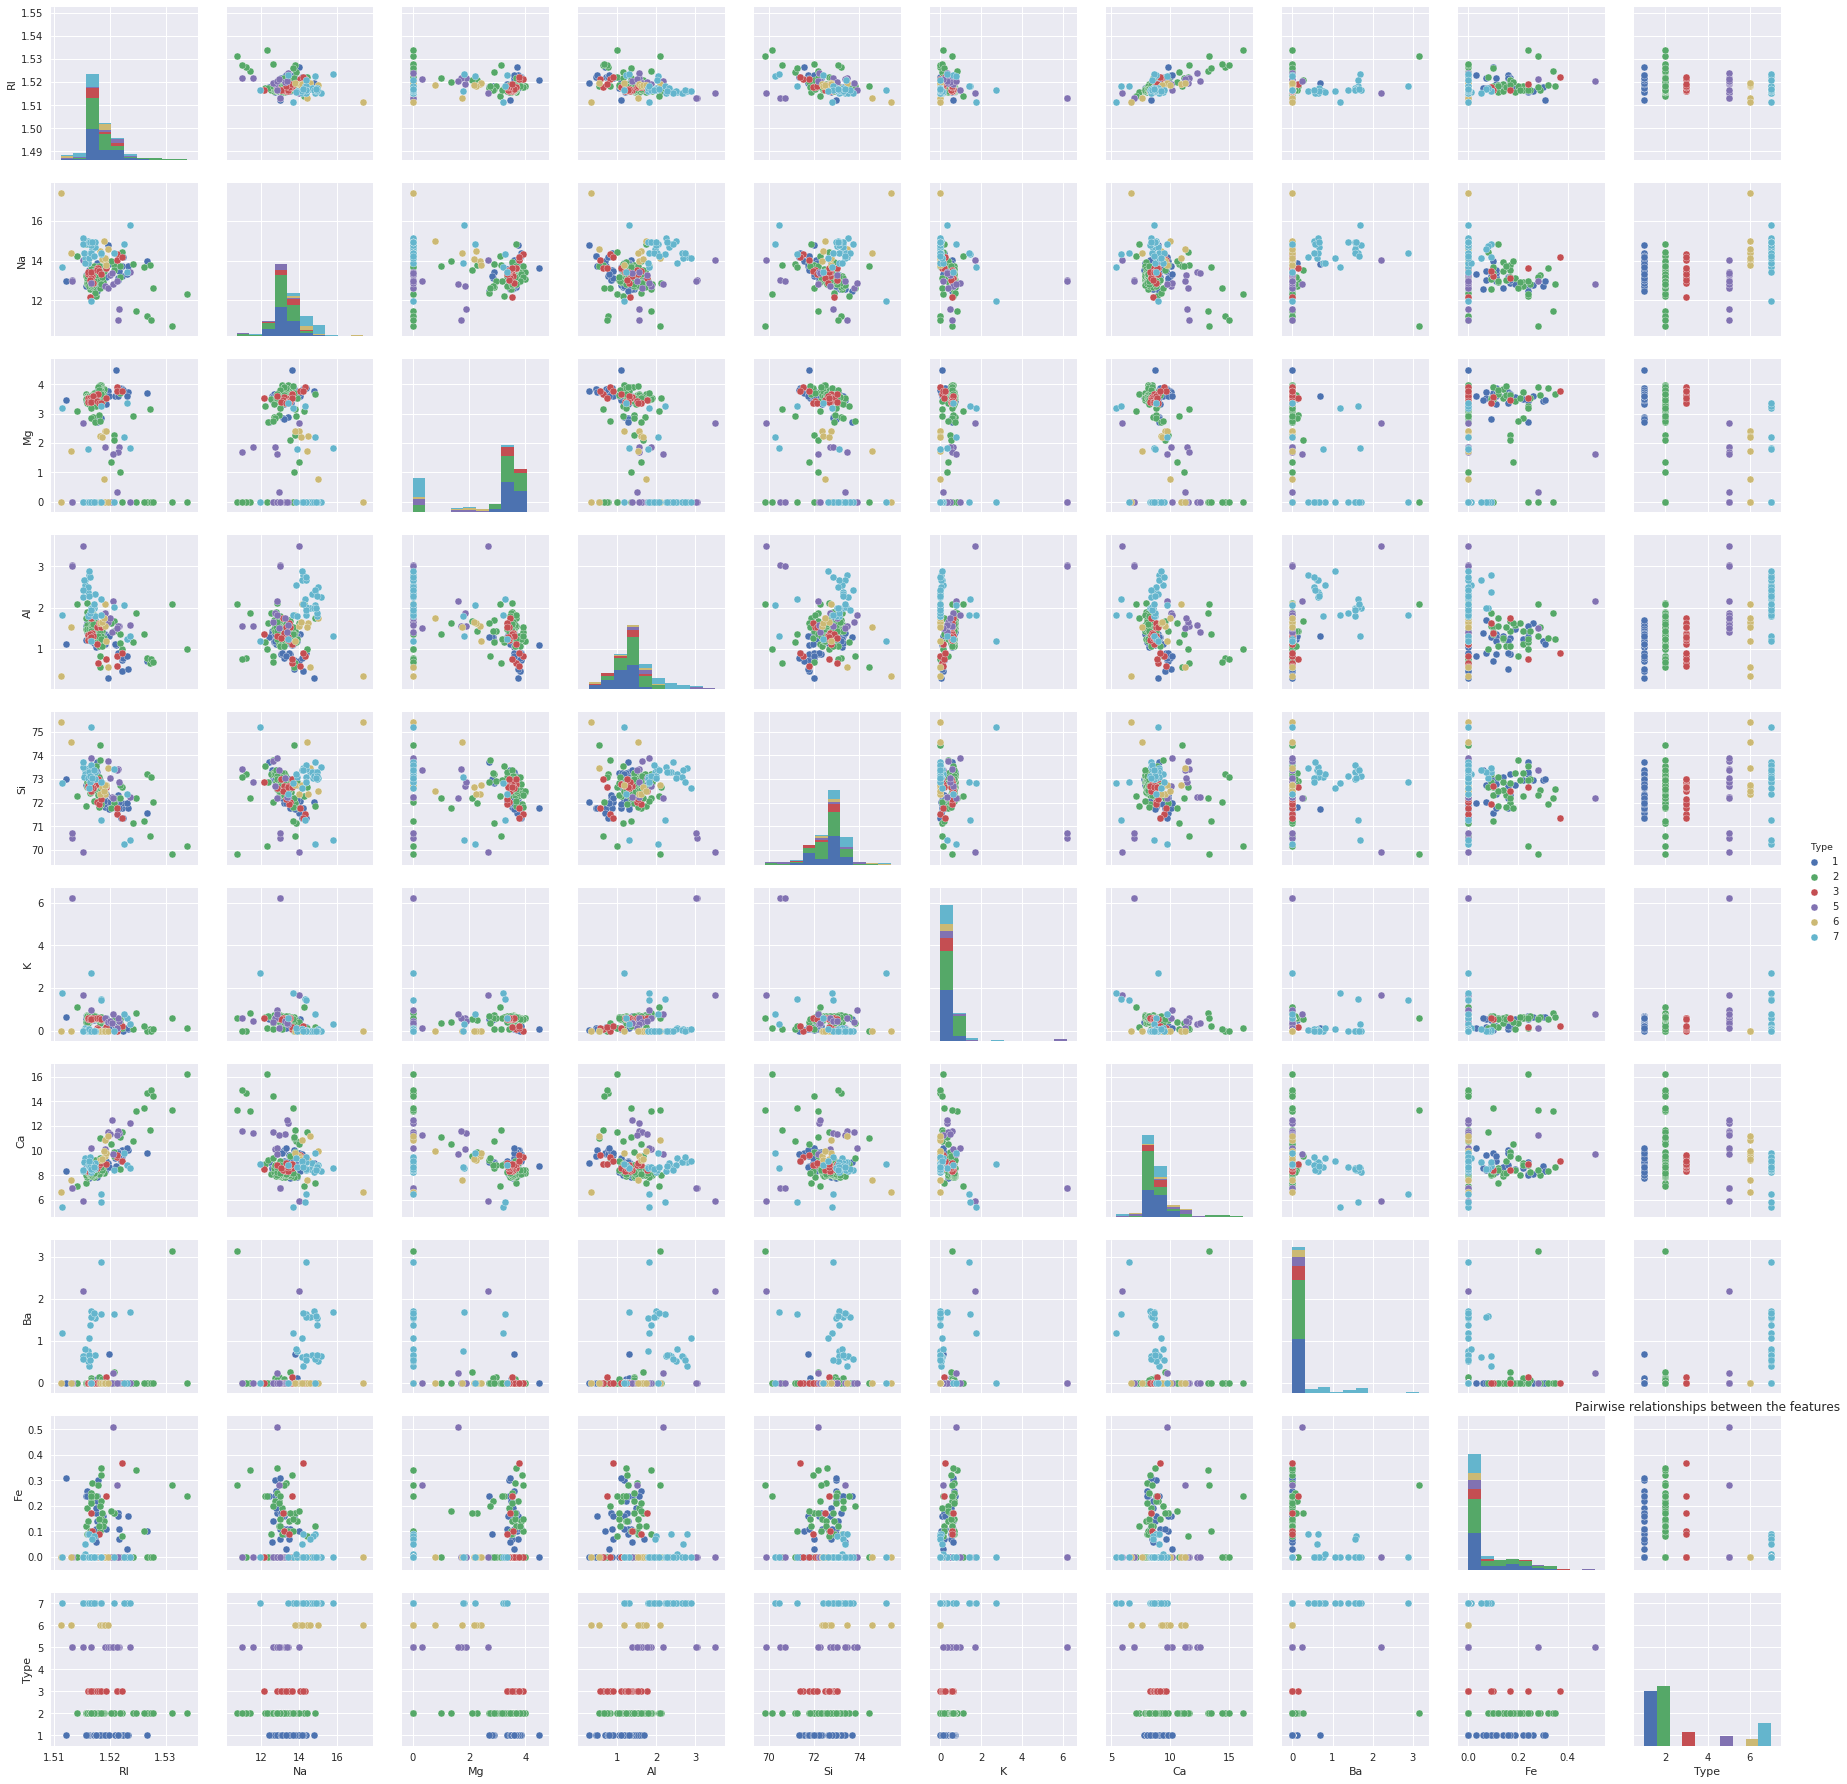

In [24]:
ax = sns.pairplot(df_glass, hue='Type')
plt.title('Pairwise relationships between the features')
plt.show()